<a href="https://colab.research.google.com/github/MBD-PT-3rd-term-IE/deep_learning_mbd_pt_2023/blob/main/yolov5_street_object_detector_final_apk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

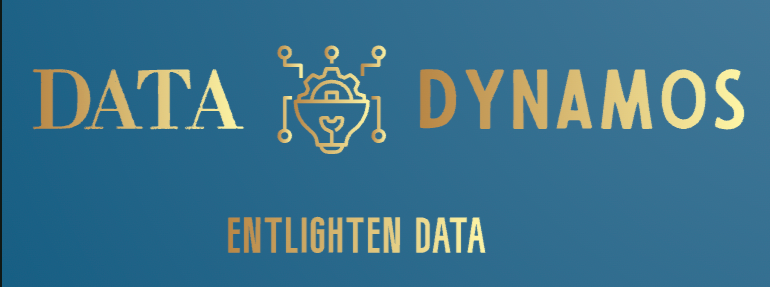


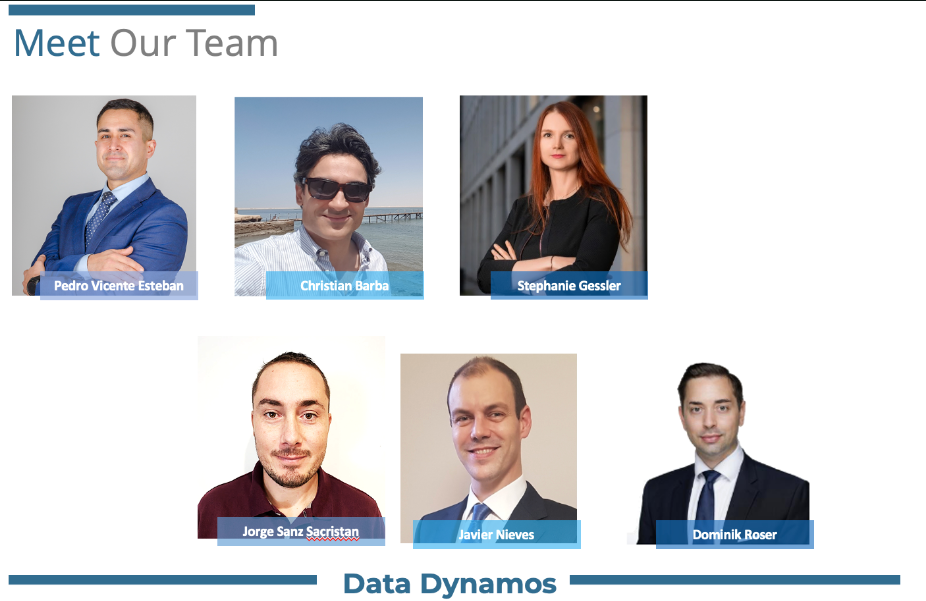

https://github.com/MBD-PT-3rd-term-IE






```
=====================================================
________          STREET OBJECT              ________
________- - - - - - - - - - -  - - - - - - - ________
________            DETECTION                ________
________              part 2                 ________
=====================================================
```


# Summary

This is a computer vision project that detects street objects as you walk past them identifying a total of 12 categories trained over a 1200 picture dataset leveraging the yolov5s framework to then transform and compile an Android apk

This deep learning project uses transfer learning to train yolov5s on our new dataset. We are not using the COCO dataset as a starting point as it contains many categories irrelevant to our use case. Instead, an 80% of the dataset has been authored by Data Dynamos while the remaining 20% is a recopilation from pictures available in platform Roboflow. 

The Roboflow platform has been used to upload the pictures and label them in the cloud. This had the advantage to allow for parallel work as pictures were hosted in Roboflow's cloud maintaining a single source of truth. LabelImg was disregarded for this reason. Roboflow also allows preprocessing steps, augmentations and training options which came handy besides the labeling.

This is the second part of a series of notebooks. The first one focused on Yolov8. We demonstrated our model worked by making inference in videos and pictures using the API and webversion of Roboflow respectively

We are now using yolov5s to make an Android app that can replicate the same steps acomplished in yolov8. We are taking the https://github.com/lp6m/yolov5s_android repository as a point of start and modifying both the Android project and the models to suit our needs. 

The procedure to get a final apk running is complex and we detail below the steps taken to get a yolov5s model running inference in Android.

We invite to install the final APK compiled included in the zip file to test how the model performs




# GitHub Repos

- Ultralytics yolov5
https://github.com/ultralytics/yolov5

- Onnx modifier
https://github.com/ZhangGe6/onnx-modifier

- Openvino
https://github.com/openvinotoolkit/openvino

- Openvino to Tensorflow
https://github.com/PINTO0309/openvino2tensorflow

- Onnx to TFlite
https://github.com/PINTO0309/onnx2tf

- Yolov5 to Android
https://github.com/lp6m/yolov5s_android

# Table of Contents

1. Pipeline
2. Preparations
3. Downloading dataset from Roboflow
4. Cloning yolov5 repo
5. Training Model with Transfer Learning
6. Model Transformations
7. Live Inference Demos

# 1. Pipeline

The pipeline will follow the next steps:

We will use our dataset from Roboflow. We need to export it with the yolov5 version marked to ensure compatibility of the yaml file.

We then clone the yolov5 repo to get the different python scripts we will be calling to train and export to onnx.

We train for two sizes, 320 and 640 using 100 epochs and batch 4. The output file is a pytorch file which will then be converted to onnx using the export function of the yolov5 repo. 

Upon training several directories and folders are created. Our weights are located in run/trainx/weights. Depending on the number of runs, the weight file will be located in the last run. We also need to double check the yaml file downloaded with roboflow. This yaml file needs to point to the right directories before calling the train. If an error is trigered, the yaml file must be opened and modified accordingly.

After getting the pt model (our weights) we call the export function to get the onnx models for each of the two models created. From here onwards, the steps are the same for the two models.

We need to open the onnx modifier tool. This tool much like Netron allows us to see the model insides. Here, we need to locate the output layers. The output layers are three most bottom Convolution layers. this is where we cut our model to avoid having only one output. Why do we cut the model?

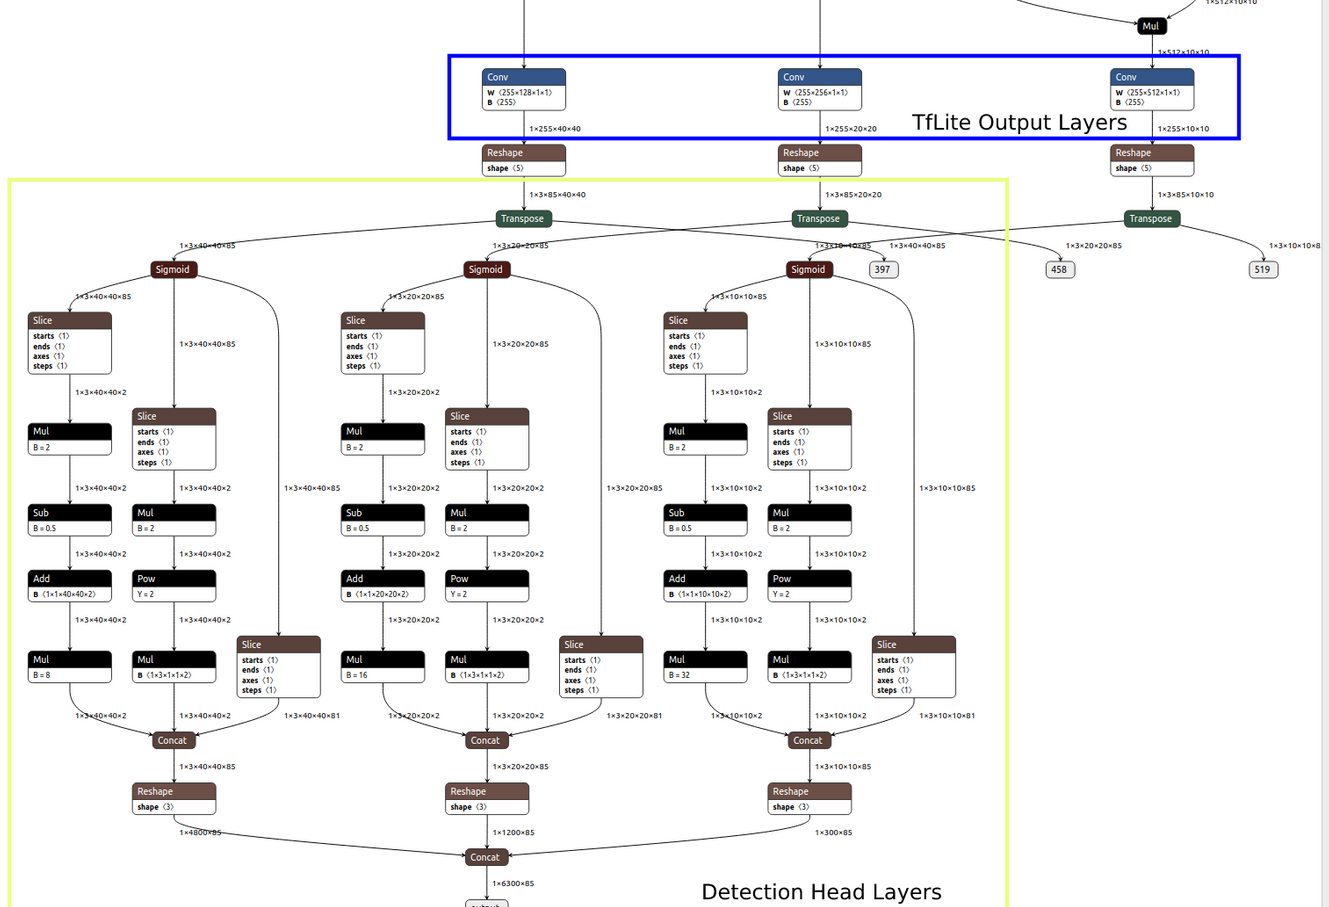





NNAPI does not support some layers included in detect head layers.
For example, The number of dimension supported by ANEURALNETWORKS_MUL operator for multiply layer is up to 4.
The input of multiply layer in detect head layers has 5 dimension, so NNAPI delegate cannot load the model.
We tried to include detect head layers into tflite in other method, but not successful yet.

For the inference, the calculation of detect head layers are implemented outside of the tflite model.
For Android, the detect head layer is implemented in C++ and executed on the CPU through JNI.

After the model is cut is exported to Openvino. This is done to quantize the model. Quantizing models is important for reducing the model size and improving inference speed. This is because quantization reduces the number of bits required to represent the weights, thus reducing the memory footprint and the computational complexity of the model. Additionally, quantization can reduce the number of parameters in the model, making the model easier to train and optimize.

After this, the model is exported to tflite fp32. This is the final step and our two models, the 320 and 640 will now be ready to be feed into Android Studio


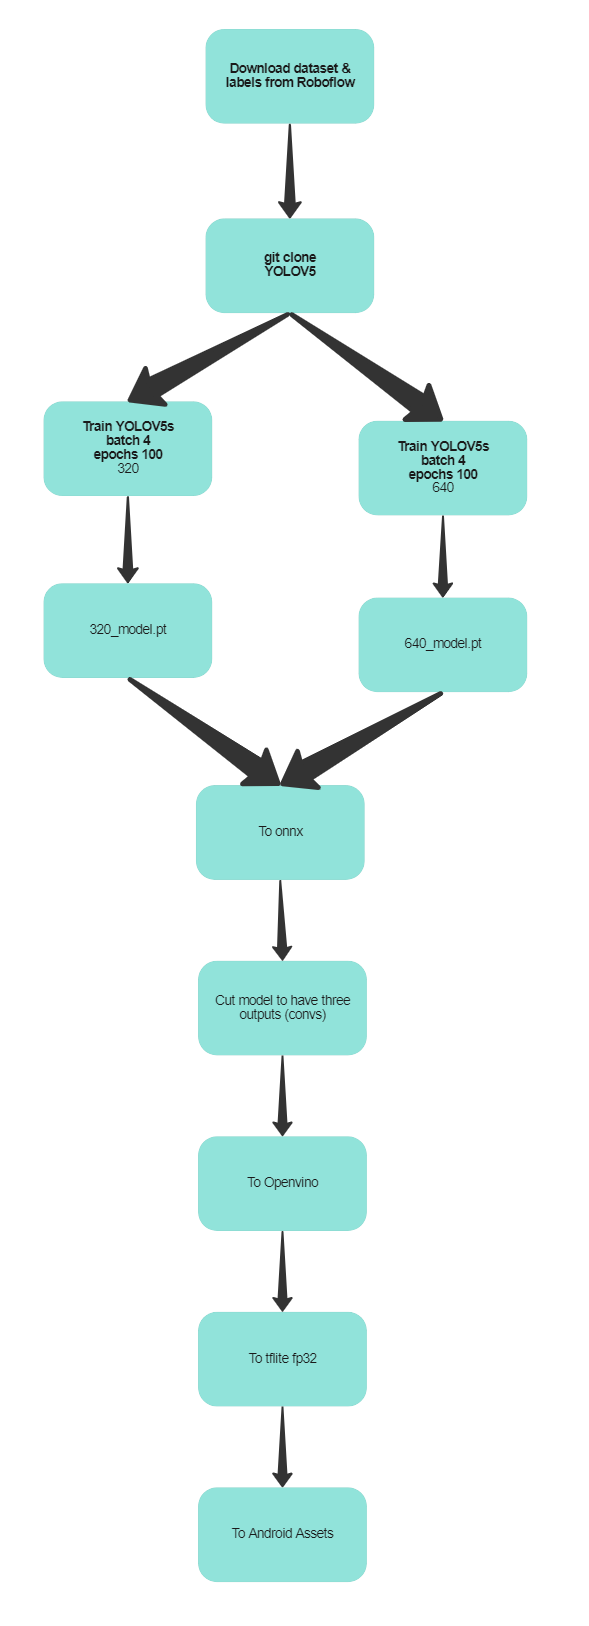

# 2. Preparations
## 2.1  Checking for Nvidia Tesla

Snippet to see which graphic card is assigned to this runtime in Google Colab

In [ ]:
!nvidia-smi

Fri Mar 17 22:28:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    18W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 2.2  Importing OS commands to navigate

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
from IPython import display
display.clear_output()

In [ ]:
%cd {HOME}

/content


# 3. Downloading dataset from Roboflow

We are using version 35 from our trials and the export option yolov5

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ow5C8sx8oFEDnaMQ6CNv")
project = rf.workspace("data-dynamos").project("streets-and-crosswalks")
#Please substitute this with other versions or yolo versions as needed
dataset = project.version(35).download("yolov5")

/content/datasets
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 KB 3.4 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=d795731c4fbfcd20546a36e16c7d0b58c454de1045a634c63fba12a40755b881
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.0.9
    Uninstalling pyparsing-3.0.9:
      Successfully uninstalled pyparsing-3.0.9
  A

loading Roboflow workspace...
loading Roboflow project...

Extracting Dataset Version Zip to Streets-and-Crosswalks-35 in yolov5pytorch:: 100%|██████████| 2364/2364 [00:00<00:00, 2434.26it/s]


# 4. Cloning yolov5 repo

In [ ]:
%cd /content
!git clone --recursive https://github.com/ultralytics/yolov5


/content
Cloning into 'yolov5'...
remote: Enumerating objects: 15305, done.
remote: Total 15305 (delta 0), reused 0 (delta 0), pack-reused 15305
Receiving objects: 100% (15305/15305), 14.19 MiB | 21.55 MiB/s, done.
Resolving deltas: 100% (10500/10500), done.


## 4.1 Installing requirements for yolov5

In [ ]:
%cd /content
!pip install -r yolov5/requirements.txt

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 622.7 kB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 63.4.3
    Uninstalling setuptools-63.4.3:
      Successfully uninstalled setuptools-63.4.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.3.0 requires setuptools<=64.0.2, but you have setuptools 67.6.0 which is incompatible.


In [ ]:
#navigating to the yolo cloned directory to use python scripts
%cd /content/yolov5
!pwd

/content/yolov5
/content/yolov5


We are creating a new directory where we will copy our weights and do all the transformations to the models later on

In [ ]:
%cd /content/yolov5
!mkdir trained_model

/content/yolov5


# 5. Training our model with Transfer Learning

Changing directory back to cloned repository to call the train function

In [ ]:
cd /content/yolov5

/content/yolov5


We will move the dataset into the yolov5 for greater convenience 


In [ ]:
mv /content/Streets-and-Crosswalks /content/yolov5

## 5.1 Training a 100 epoch model for images 320x320

The 320 model is appropriate in YOLO because it is a smaller model that is faster and more efficient than larger models. It is able to detect objects quickly and accurately, making it ideal for real-time applications. Additionally, it requires less memory and computational power, making it more cost-effective and easier to deploy.

In [ ]:
!python train.py --img 320 --batch 4 --epochs 100\
--data Streets-and-Crosswalks-35/data.yaml\
--weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=Streets-and-Crosswalks-35/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=4, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015

We now copy the weights into our created directory for better location

In [ ]:
cp /content/yolov5/runs/train/exp/weights/best.pt /content/yolov5/trained_model/yolo_android_320_ourdata_100epochs.pt

## 5.2 Training a 100 epoch model for images 640x640


The 640 model is more accurate than other versions due to increased resolution, making it an ideal choice for applications that require high accuracy.

In [ ]:
!python train.py --img 640 --batch 4 --epochs 100\
--data Streets-and-Crosswalks-35/data.yaml\
--weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=Streets-and-Crosswalks-35/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=4, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015

In [ ]:
cp /content/yolov5/runs/train/exp2/weights/best.pt /content/yolov5/trained_model/yolo_android_640_ourdata_100epochs.pt

# 6. Model Transformations

## 6.1 Installing required dependencies

In [ ]:
# Install the MLTK (if necessary)
!pip install --upgrade silabs-mltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 84.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.3/2

In [ ]:
"""Install the standard ONNX Python package so that we can 
read the .onnx formatted model file"""
!pip install onnx onnx_tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.4 MB/s eta 0:00:00


In [ ]:
"""Install the onnsim Python package
This can help reduce the complexity of the generated ONNX model file (quantize)
https://github.com/daquexian/onnx-simplifier """
!pip install onnx-simplifier onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.7/238.7 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.9 MB/s eta 0:00:00
  Attempting uninstall: pygments
    Found existing installation: Pygments 2.6.1
    Uninstalling Pygments-2.6.1:
      Successfully uninstalled Pygments-2.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

OpenVINO models are better than ONNX or PyTorch models in a few key ways:

1. OpenVINO models have optimized inference performance on Intel CPUs and GPUs. This means that OpenVINO models are more efficient and can run faster than other models.

2. OpenVINO models are optimized for Intel hardware and are designed to take full advantage of Intel's hardware capabilities. This means that OpenVINO models can provide higher accuracy and faster inference times than other models.

3. OpenVINO models are more portable than other models. This means that they can be deployed on a variety of different hardware platforms, including Intel CPUs, GPUs, FPGAs, and VPUs.

4. OpenVINO models are more cost-effective than other models. This is because they are optimized for Intel hardware and can provide faster inference times and higher accuracy than other models.

In [ ]:
"""Install the openvino_dev Python package
This allows for converting the ONNX model to an intermediate 
format so we can then convert it to a TF-Lite model format
https://docs.openvino.ai/ """
!pip install openvino_dev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 35.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 43.2 MB/s eta 0:00:00
  Created wheel for jstyleson: filename=jstyleson-0.0.2-py3-none-any.whl size=2398 sha256=21f8e3932d30db471bf34640e3a7539a294e07349946251b51661c3a86d0c989
  Stored in directory: /root/.cache/pip/wheels/d4/2a/06/11202ea86be0f51f34e9411d691e25b991d188d93ab4d3e551
Successfully built jstyleson
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.4
    Uninstalling p

In [ ]:
""" Install the openvino2tensorflow Python package
This allows for converting from the openvino format to the .tflite model format
We primarily need this so we can convert from the NCHW used by .onnx 
to the NHWC used by .tflite
https://github.com/PINTO0309/openvino2tensorflow """
!pip install openvino2tensorflow  tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 KB 3.4 MB/s eta 0:00:00


In [ ]:
#Installing tensorflow version to match Android development pipeline followed
pip install tensorflow==2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 6.2 Exporting from pytorch to onnx
We call the export script from yolov5 with arguments include onnx

In [ ]:
#generate onnx model for 320
%cd /content/yolov5
!python3 export.py --weights trained_model/yolo_android_320_ourdata_100epochs.pt --img-size 320 320 --include onnx


/content/yolov5
export: data=data/coco128.yaml, weights=['trained_model/yolo_android_320_ourdata_100epochs.pt'], imgsz=[320, 320], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 7047883 parameters, 0 gradients, 15.9 GFLOPs

PyTorch: starting from trained_model/yolo_android_320_ourdata_100epochs.pt with output shape (1, 6300, 19) (13.7 MB)
requirements: YOLOv5 requirement "onnx>=1.12.0" not found, attempting AutoUpdate...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.11.0 requires protobuf<3.20,>=3.9.2, but you h

In [ ]:
#generate onnx model for 640
%cd /content/yolov5
!python3 export.py --weights trained_model/yolo_android_640_ourdata_100epochs.pt --img-size 640 640 --include onnx


/content/yolov5
export: data=data/coco128.yaml, weights=['trained_model/yolo_android_640_ourdata_100epochs.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
Model summary: 157 layers, 7047883 parameters, 0 gradients, 15.9 GFLOPs

PyTorch: starting from trained_model/yolo_android_640_ourdata_100epochs.pt with output shape (1, 25200, 19) (13.8 MB)

ONNX: starting export with onnx 1.13.1...
ONNX: export success ✅ 1.2s, saved as trained_model/yolo_android_640_ourdata_100epochs.onnx (27.3 MB)

Export complete (2.7s)
Results saved to /content/yolov5/trained_model
Detect:          python detect.py --weights trained_model/yolo_android_640_ourdata_100epochs.onnx 
Va

# 6.3 Cutting the model with Onnx modifier
Now we convert and cut the model, and save it back here for more postprocessing

Below a demonstration of how the onnx modifier works

https://github.com/ZhangGe6/onnx-modifier

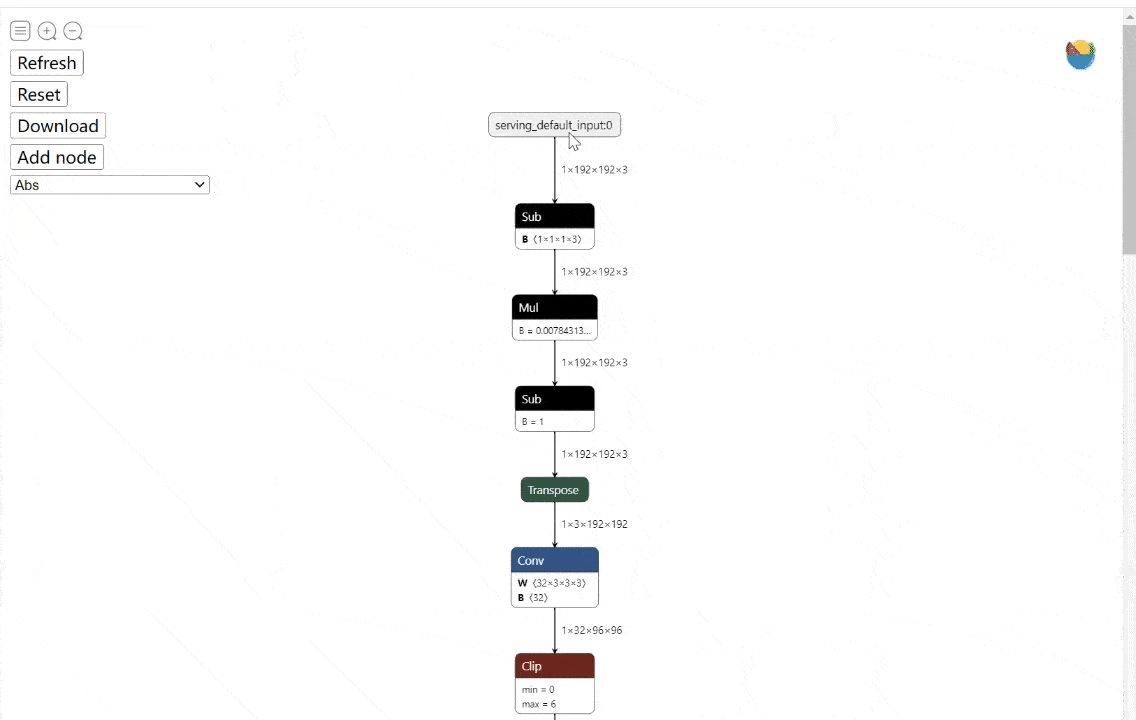

The new cut model will be saved in the trained model folder for further processing


# 6.4 Exporting modified Onnx model into Openvino
The next part of the pipeline involves doing one further conversion into openvino. Openvino allows further quantization to make the model simpler and more ready to be deployed in a mobile app


In [ ]:
import sys
import os
import onnxsim
import onnx

# Import the model optimizer tool from the openvino_dev package
from openvino.tools.mo import main as mo_main
import onnx
from onnx_tf.backend import prepare
from mltk.utils.shell_cmd import run_shell_cmd


In [ ]:
!pwd

/content/yolov5


In [ ]:
# Load the ONNX model for 320

model_path_convert = r"/content/yolov5/trained_model/modified_yolo_android_320_ourdata_100epochs.onnx"

onnx_model = onnx.load(model_path_convert)
tf_rep = prepare(onnx_model)

# Get the input tensor shape
input_tensor = tf_rep.signatures[tf_rep.inputs[0]]
input_shape = input_tensor.shape
input_shape_str = '[' + ','.join([str(x) for x in input_shape]) + ']'
print(input_shape_str)

openvino_out_dir = r"/content/yolov5/trained_model/openvino"
os.makedirs(openvino_out_dir, exist_ok=True)

print(f'Generating openvino at: {openvino_out_dir}')
cmd = [ 
    sys.executable, mo_main.__file__, 
    '--input_model', model_path_convert,
    '--input_shape', input_shape_str,
    '--output_dir', openvino_out_dir,
    '--data_type', 'FP32'

]
retcode, retmsg = run_shell_cmd(cmd,  outfile=sys.stdout)
assert retcode == 0, 'Failed to do conversion' 

[1,3,320,320]
Generating openvino at: /content/yolov5/trained_model/openvino
[ WARNING ]  Use of deprecated cli option --data_type detected. Option use in the following releases will be fatal. 
[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /content/yolov5/trained_model/openvino/modified_yolo_android_320_ourdata_100epochs.xml
[ SUCCESS ] BIN file: /content/yolov5/trained_model/openvino/modified_yolo_android_320_ourdata_100epochs.bin


In [ ]:
# Load the ONNX model for 640

model_path_convert = r"/content/yolov5/trained_model/modified_yolo_android_640_ourdata_100epochs.onnx"

onnx_model = onnx.load(model_path_convert)
tf_rep = prepare(onnx_model)

# Get the input tensor shape
input_tensor = tf_rep.signatures[tf_rep.inputs[0]]
input_shape = input_tensor.shape
input_shape_str = '[' + ','.join([str(x) for x in input_shape]) + ']'
print(input_shape_str)

openvino_out_dir = r"/content/yolov5/trained_model/openvino"
os.makedirs(openvino_out_dir, exist_ok=True)

print(f'Generating openvino at: {openvino_out_dir}')
cmd = [ 
    sys.executable, mo_main.__file__, 
    '--input_model', model_path_convert,
    '--input_shape', input_shape_str,
    '--output_dir', openvino_out_dir,
    '--data_type', 'FP32'

]
retcode, retmsg = run_shell_cmd(cmd,  outfile=sys.stdout)
assert retcode == 0, 'Failed to do conversion' 

[1,3,640,640]
Generating openvino at: /content/yolov5/trained_model/openvino
[ WARNING ]  Use of deprecated cli option --data_type detected. Option use in the following releases will be fatal. 
[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: /content/yolov5/trained_model/openvino/modified_yolo_android_640_ourdata_100epochs.xml
[ SUCCESS ] BIN file: /content/yolov5/trained_model/openvino/modified_yolo_android_640_ourdata_100epochs.bin


## 6.5 Converting Openvino to TensorFlow Lite (FP32)

 TFLite FP32, FP16, and INT refer to the precision of the model's weights and activations. FP32 (float 32) is the most precise and requires the most memory, while INT (integer) is the least precise but requires the least memory. FP16 (float 16) is a compromise between the two.

For mobile deployment, FP16 is usually the best balance between precision and memory usage.

We have chosen for our deployment FP32.

In [ ]:
import os 
from mltk.utils.shell_cmd import run_shell_cmd

xml_model_totflite = r'/content/yolov5/trained_model/openvino/modified_yolo_android_320_ourdata_100epochs.xml'

openvino2tensorflow_out_dir = r'/content/yolov5/trained_model/openvino2tensorflow_320'
openvino_xml_name = xml_model_totflite


if os.name == 'nt':
  openvino2tensorflow_exe_cmd = [sys.executable, os.path.join(os.path.dirname(sys.executable), 'openvino2tensorflow')]
else:
  openvino2tensorflow_exe_cmd = ['openvino2tensorflow']

print(f'Generating openvino2tensorflow model at: {openvino2tensorflow_out_dir} ...')
cmd = openvino2tensorflow_exe_cmd + [ 
    '--model_path', openvino_xml_name,
    '--model_output_path', openvino2tensorflow_out_dir,
    '--output_saved_model',
    '--output_no_quant_float32_tflite'
]

retcode, retmsg = run_shell_cmd(cmd)
assert retcode == 0, retmsg
print('done')

Generating openvino2tensorflow model at: /content/yolov5/trained_model/openvino2tensorflow_320 ...
done


In [ ]:
import os 
from mltk.utils.shell_cmd import run_shell_cmd

xml_model_totflite = r'/content/yolov5/trained_model/openvino/modified_yolo_android_640_ourdata_100epochs.xml'

openvino2tensorflow_out_dir = r'/content/yolov5/trained_model/openvino2tensorflow_640'
openvino_xml_name = xml_model_totflite


if os.name == 'nt':
  openvino2tensorflow_exe_cmd = [sys.executable, os.path.join(os.path.dirname(sys.executable), 'openvino2tensorflow')]
else:
  openvino2tensorflow_exe_cmd = ['openvino2tensorflow']

print(f'Generating openvino2tensorflow model at: {openvino2tensorflow_out_dir} ...')
cmd = openvino2tensorflow_exe_cmd + [ 
    '--model_path', openvino_xml_name,
    '--model_output_path', openvino2tensorflow_out_dir,
    '--output_saved_model',
    '--output_no_quant_float32_tflite'
]

retcode, retmsg = run_shell_cmd(cmd)
assert retcode == 0, retmsg
print('done')

Generating openvino2tensorflow model at: /content/yolov5/trained_model/openvino2tensorflow_640 ...
done


### End of pipeline. Model can now be taken to Android Studio

Further inference and results will be provided outside of this notebook in a live test with an Android phone

# 7. Live demos
After some processing in Android Studio, we are able to deploy an APK, install it and test it on the streets

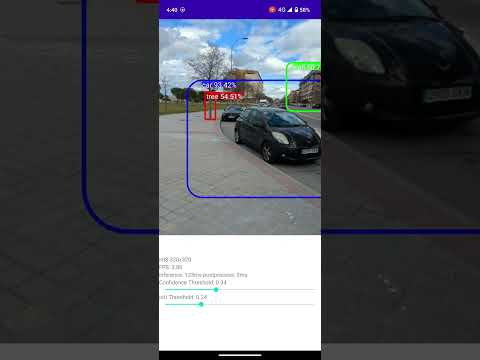

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('G-D3P-5c6a4')

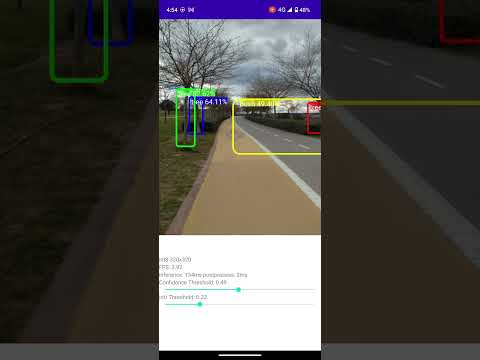

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('42IJC3yeZ8o')

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('MWThk-4Hcc8')